# GCS Upload / Download with CSEK encryption key (Secret Manager)

- Google Cloud Console에서 Upload된 이미지들을 미리보기 할 수 없도록 Customer-Supplied Encryption Key(CSEK)를 사용
- CSEK는 Secret Manger에 등록하여 관리하는 예제

In [ ]:
! pip3 install google-cloud-secret-manager

In [41]:
import os
PROJECT_ID = "PROJECT_ID"
BUCKET = "BUCKET"

In [45]:
import base64
import os

def generate_encryption_key():
    # Generates a 256 bit (32 byte) AES encryption key and prints the base64 representation.

    key = os.urandom(32)
    encoded_key = base64.b64encode(key).decode("utf-8")

    return encoded_key


### Encryption Key 생성

In [ ]:
GCS_CSEK=generate_encryption_key()

### Encryption Key를 Secret Manager에 등록

In [6]:
! echo {GCS_CSEK} | gcloud secrets create gcs-csek --data-file=- --replication-policy=user-managed --locations=asia-northeast3

Created version [1] of the secret [gcs-csek].


### 생성된 secret 확인

In [53]:
! gcloud secrets list

NAME      CREATED              REPLICATION_POLICY  LOCATIONS
gcs-csek  2025-02-04T13:58:11  user_managed        asia-northeast3


In [60]:
from google.cloud import secretmanager
import base64

def access_secret_version(
    project_id: str, secret_id: str, version_id: str
) -> secretmanager.AccessSecretVersionResponse:
    """
    Access the payload for the given secret version if one exists. The version
    can be a version number as a string (e.g. "1") or an alias (e.g. "latest").
    """

    # Create the Secret Manager client.
    client = secretmanager.SecretManagerServiceClient()

    # Build the resource name of the secret version.
    name = f"projects/{project_id}/secrets/{secret_id}/versions/{version_id}"

    # Access the secret version.
    response = client.access_secret_version(request={"name": name})

    enc_key = base64.b64decode(response.payload.data)

    return enc_key

In [61]:
from google.cloud import storage

def upload_encrypted_blob(
    bucket_name,
    source_file_name,
    destination_blob_name,
    secret_name,
    sec_version
):
    
    storage_client = storage.Client()
    bucket = storage_client.bucket(bucket_name)

    blob = bucket.blob(
        destination_blob_name, encryption_key=access_secret_version(PROJECT_ID, secret_name, sec_version)
    )

    blob.upload_from_filename(source_file_name)

    print(
        f"File {source_file_name} uploaded to {destination_blob_name}."
    )

In [62]:
from google.cloud import storage

def download_encrypted_blob(
    bucket_name,
    source_blob_name,
    destination_file_name,
    secret_name,
    sec_version
):
    
    storage_client = storage.Client()
    bucket = storage_client.bucket(bucket_name)
    blob = bucket.blob(source_blob_name, encryption_key=access_secret_version(PROJECT_ID, secret_name, sec_version))
    blob.download_to_filename(destination_file_name)

    print(
        f"Blob {source_blob_name} downloaded to {destination_file_name}."
    )

### 파일 업로드

In [58]:
upload_encrypted_blob(BUCKET, "./cat.png","cat-csek.png","gcs-csek", "1")

File ./cat.png uploaded to cat-csek.png.


### Bucket에 업로드된 이미지를 확인
CSEK를 Encryption Key로 사용하고, Preview가 되지 않음을 확인할 수 있음

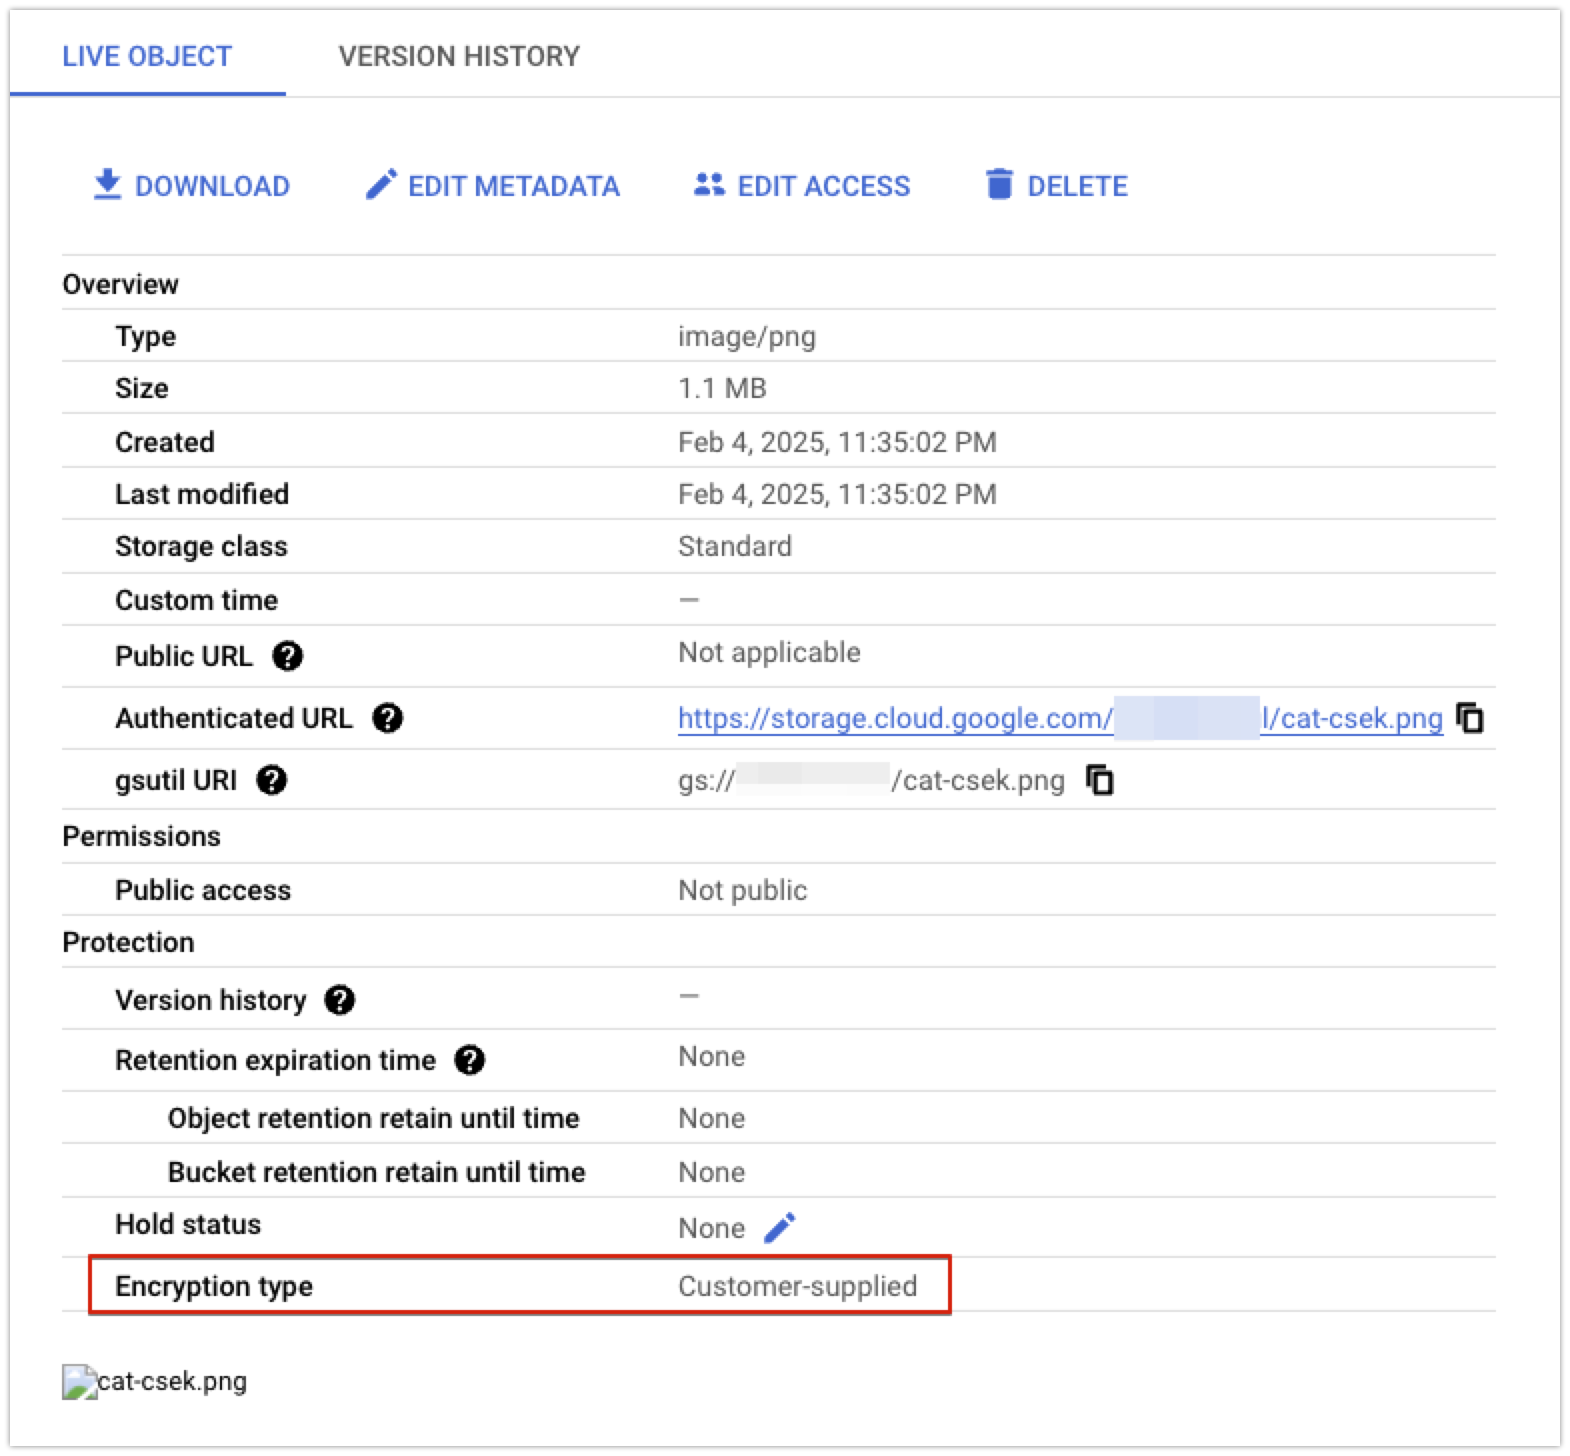

### 파일 다운로드

In [59]:
download_encrypted_blob(BUCKET, "cat-csek.png","./cat-download.png","gcs-csek", "1")

Blob cat-csek.png downloaded to ./cat-download.png.


### 다운로드 이미지 확인
CSEK로 Decrypt하여 이미지가 정상적으로 보임을 확인


![image.png](./cat-download.png)